/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


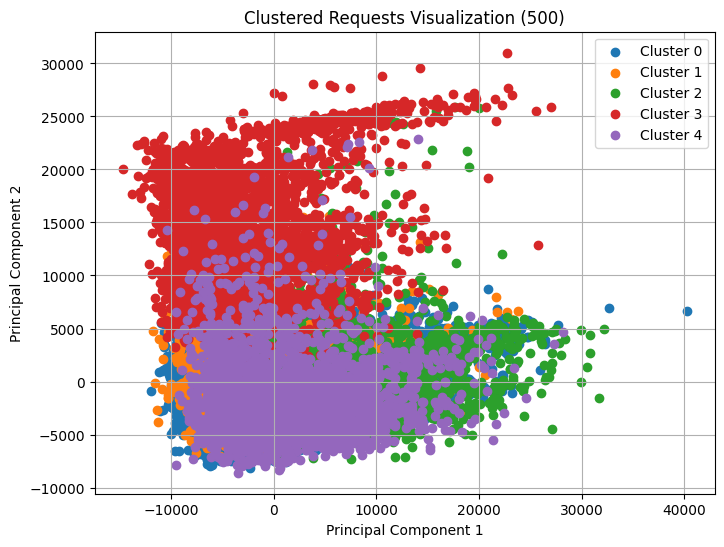

In [ ]:
import os
import pandas as pd
from transformers import BertTokenizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
df = pd.read_csv("/content/requests_only.csv")

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Sample a subset of the data for processing
sample_df = df.sample(n=50000, random_state=42)

# Tokenize the requests
tokenized_inputs = tokenizer(sample_df['request'].tolist(), padding=True, truncation=True, return_tensors='pt')
#tokenized_requests = [tokenizer.tokenize(request.lower()) for request in sample_df['request'].tolist()]


# Perform MiniBatchKMeans clustering on tokenized inputs
kmeans = MiniBatchKMeans(n_clusters=5, random_state=0, batch_size=100).fit(tokenized_inputs['input_ids'])

# Dimensionality reduction using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(tokenized_inputs['input_ids'])

# Get cluster assignments
cluster_labels = kmeans.labels_

# Plot clusters
plt.figure(figsize=(8, 6))
for cluster_id in range(len(np.unique(cluster_labels))):
    cluster_points = embeddings_2d[cluster_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}')

plt.title('Clustered Requests Visualization (500)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
from collections import Counter

# Define a list of words to skip
skip_words = ['the', 'of', 'and', 'following', 'to', 'in', 'a', 'for', 'on', 'or', 'an', 'that', 'with', 'is', '.', ':', "'", '-', ',', '[PAD]', '[CLS]', '[SEP]', '"']

# Get the tokenized requests
tokenized_requests = tokenizer(sample_df['request'].tolist(), padding=True, truncation=True, return_tensors='pt')['input_ids']

# Create a dictionary to store word frequencies for each cluster
cluster_word_freq = {cluster_id: Counter() for cluster_id in np.unique(cluster_labels)}

# Update word frequencies for each cluster
for i, (tokens, cluster_id) in enumerate(zip(tokenized_requests, cluster_labels)):
    token_list = tokenizer.convert_ids_to_tokens(tokens.numpy().tolist())
    # Filter out the words in the skip_words list
    filtered_tokens = [token for token in token_list if token not in skip_words]
    cluster_word_freq[cluster_id].update(filtered_tokens)

# Print the 15 most used words per cluster
for cluster_id, word_freq in cluster_word_freq.items():
    print(f"Cluster {cluster_id} Most Used Words (Excluding Skip Words):")
    print(word_freq.most_common(15))  # Print top 15 most common words


Cluster 0 Most Used Words (Excluding Skip Words):
[('given', 4714), ('sentence', 4646), ('?', 3362), ('generate', 3119), ('list', 2814), ('what', 2738), ('create', 2392), ('describe', 2234), ('write', 1936), ('about', 1932), ('two', 1851), ('this', 1809), ('explain', 1721), ('it', 1694), ('how', 1666)]
Cluster 1 Most Used Words (Excluding Skip Words):
[('given', 647), ('sentence', 543), ('generate', 527), ('list', 481), ('?', 462), ('describe', 445), ('create', 428), ('explain', 347), ('write', 338), ('what', 326), ('two', 313), ('##s', 296), ('about', 282), ('how', 267), ('three', 263)]
Cluster 2 Most Used Words (Excluding Skip Words):
[('sentence', 550), ('given', 439), ('?', 302), ('it', 248), ('generate', 241), ('what', 239), ('re', 232), ('create', 219), ('write', 210), ('list', 208), ('##write', 193), ('two', 179), ('using', 179), ('##s', 176), ('describe', 174)]
Cluster 3 Most Used Words (Excluding Skip Words):
[('create', 645), ('generate', 640), ('given', 588), ('sentence', 51

In [ ]:
def filter_unique_words(cluster_word_freq):
    # Create a copy of the cluster_word_freq dictionary
    filtered_cluster_word_freq = cluster_word_freq.copy()

    # Iterate over each cluster
    for cluster_id, word_freq in cluster_word_freq.items():
        # Create a set of words present in other clusters
        other_clusters_words = set()
        for other_cluster_id, other_word_freq in cluster_word_freq.items():
            if other_cluster_id != cluster_id:
                other_clusters_words.update(other_word_freq.keys())

        # Remove words present in other clusters
        filtered_cluster_word_freq[cluster_id] = {word: freq for word, freq in word_freq.items() if word not in other_clusters_words}

    return filtered_cluster_word_freq

# Example usage
filtered_cluster_word_freq = filter_unique_words(cluster_word_freq)

# Print the filtered word frequencies for each cluster
for cluster_id, word_freq in filtered_cluster_word_freq.items():
    print(f"Cluster {cluster_id} Unique Words (Excluding Words in Other Clusters):")
    # Print top 15 most common words
    sorted_word_freq = sorted(word_freq.items(), key=lambda item: item[1], reverse=True)
    print(sorted_word_freq[:15])



Cluster 0 Unique Words (Excluding Words in Other Clusters):
[('printers', 28), ('facing', 25), ('dye', 25), ('bill', 23), ('frequent', 20), ('cards', 18), ('oldest', 18), ('kit', 17), ('followed', 17), ('wish', 17), ('wedding', 16), ('influential', 16), ('invented', 16), ('fifth', 14), ('seems', 13)]
Cluster 1 Unique Words (Excluding Words in Other Clusters):
[('introduces', 4), ('protective', 3), ('discoveries', 3), ('sack', 3), ('bunch', 3), ('##ome', 3), ('##try', 3), ('rewards', 3), ('thermal', 3), ('spicy', 3), ('##ator', 3), ('swallow', 3), ('colony', 3), ('132', 2), ('expectation', 2)]
Cluster 2 Unique Words (Excluding Words in Other Clusters):
[('##hs', 6), ('##leg', 5), ('weighs', 5), ('ser', 5), ('##put', 3), ('##hism', 3), ('apache', 3), ('plots', 3), ('##rop', 3), ('##tem', 3), ('nowadays', 3), ('##umble', 3), ('##rti', 3), ('##lizer', 3), ('loosen', 3)]
Cluster 3 Unique Words (Excluding Words in Other Clusters):
[('##rise', 8), ('ashe', 6), ('remembering', 5), ('thoughtful